In [10]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon, iradon
from skimage.data import shepp_logan_phantom
from skimage.transform import resize
from PIL import Image
from skimage.restoration import denoise_tv_chambolle
import bm3d 


import deepinv as dinv
import torch
from torchvision import transforms
from deepinv.models import DnCNN, DRUNet, GSDRUNet, GSPnP
from deepinv.optim.data_fidelity import L2
from deepinv.optim.prior import PnP
from deepinv.optim.optimizers import optim_builder
from deepinv.utils.demo import load_url_image, get_image_url
from deepinv.utils.plotting import plot, plot_curves

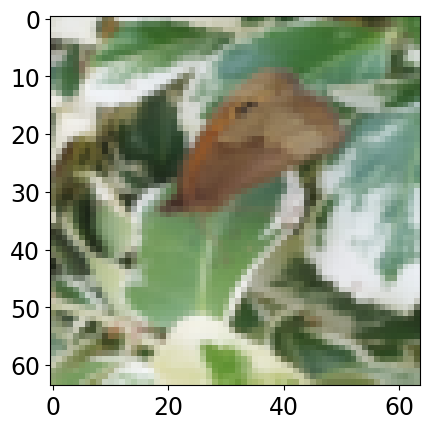

In [11]:
path = "data/butterfly.png"
image = Image.open(path)
dim = 64
transform = transforms.Compose([transforms.Resize((dim, dim)), transforms.ToTensor(),])
img = transform(image)
plt.imshow(img.permute(1, 2, 0))
img = img.reshape(1, 3, dim, dim)

# Deepinv Implementation

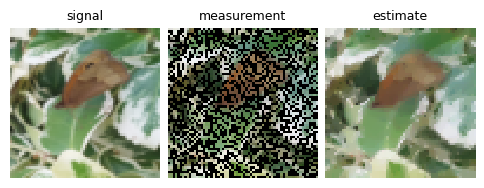

In [38]:
noise = 0.01
physics = dinv.physics.Inpainting((3, 64, 64), mask = 0.5,
                                   noise_model=dinv.physics.GaussianNoise(sigma= noise))

data_fidelity = dinv.optim.data_fidelity.L2()
prior = dinv.optim.prior.PnP(denoiser=dinv.models.TVDenoiser())
model = dinv.optim.optim_builder(iteration="PGD", prior=prior, data_fidelity=data_fidelity,
                                 params_algo={"stepsize": 1.0, "g_param": noise})
y = physics(img)
x_hat, tv_metrics = model(y, physics, compute_metrics = True)
plot([img, y, x_hat], ["signal", "measurement", "estimate"], rescale_mode='clip')

In [53]:
params = {"stepsize": 1, "g_param": noise}

max_iter = 500
channels = 3
forward = L2()

# DnCNN Zhang 2017 denoiser
dncnn = DnCNN(
    in_channels=channels,
    out_channels=channels,
    pretrained="download",  
    device="cpu",
)

# Zhang 2021 denoiser
drunet = DRUNet(
    in_channels= channels,
    out_channels= channels,
    pretrained="download",
    device="cpu",
)

# Classical priors

bm3dprior = dinv.models.BM3D()


In [54]:
priorbm3d = PnP(denoiser = bm3dprior)
dncnnprior = PnP(denoiser = dncnn)
drunetprior = PnP(denoiser = drunet)

In [55]:
#DnCNN
model2 = optim_builder(
    iteration="PGD",
    prior= dncnnprior,
    data_fidelity = L2(),
    early_stop = True,
    max_iter = max_iter,
    verbose = True,
    params_algo=params,
)


#DRUNet
model3 = optim_builder(
    iteration="PGD",
    prior= drunetprior,
    data_fidelity = L2(),
    early_stop = True,
    max_iter = 50,
    verbose = True,
    params_algo=params,
    
)

modelbm3d = optim_builder(
    iteration="PGD",
    prior= priorbm3d,
    data_fidelity = L2(),
    early_stop = True,
    max_iter = max_iter,
    verbose = True,
    params_algo=params,
)
x = img

In [56]:
x_model2, metrics2 = model2(y, physics, x_gt = x, compute_metrics = True)
x_model3, metrics3 = model3(y, physics, x_gt = x, compute_metrics = True)

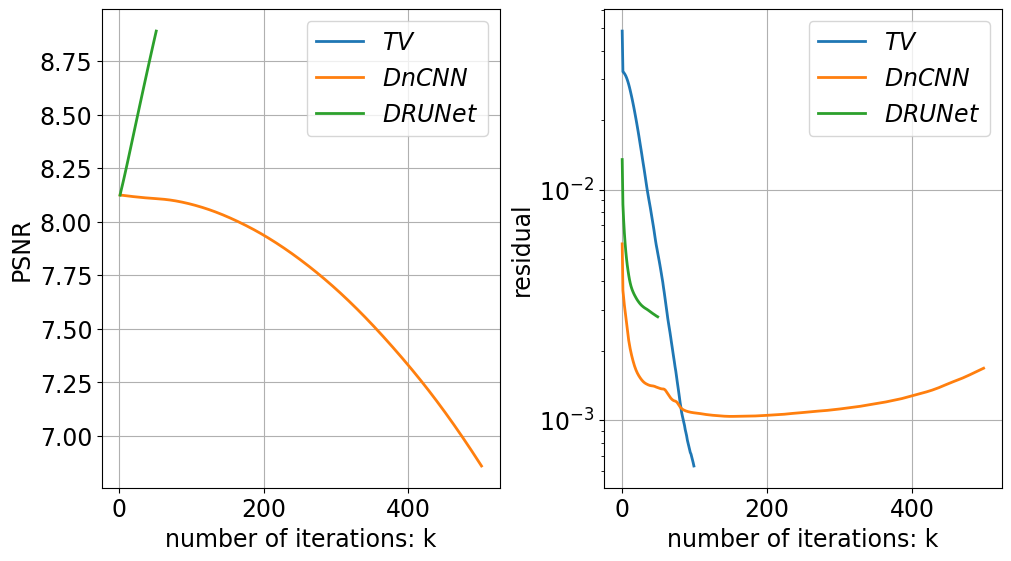

In [57]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5.5), constrained_layout = True)
def plot_psnrs_residuals(lists, method, color='blue'):
    """
    Peak-signal-to-noise ratio (PSNR) and residual plots vs iterations for a prior denoiser
    """


    psnrs = list(lists.values())[0]
    residuals = list(lists.values())[1]
    psnrs = np.array(psnrs).flatten()
    residuals = np.array(residuals).flatten()
    #fig.suptitle(method)
    ax1.plot(range(1, len(psnrs) + 1), psnrs, label = method)
    ax1.set_ylabel('PSNR')
    ax1.set_xlabel('number of iterations: k')
    ax1.grid(True)

    ax2.semilogy(residuals, label = method)
    ax2.set_ylabel('residual')
    ax2.set_xlabel('number of iterations: k')
    ax2.grid(True)



plot_psnrs_residuals(tv_metrics, '$TV$')
plot_psnrs_residuals(metrics2, '$DnCNN$')
plot_psnrs_residuals(metrics3, '$DRUNet$')
#plot_psnrs_residuals(metricsbm3d, '$\\sigma = 1$')

ax1.legend()
ax2.legend()

In [ ]:
#bm3d
x_modelbm3d, metricsbm3d = modelbm3d(y, radon, x_gt = x, compute_metrics = True)

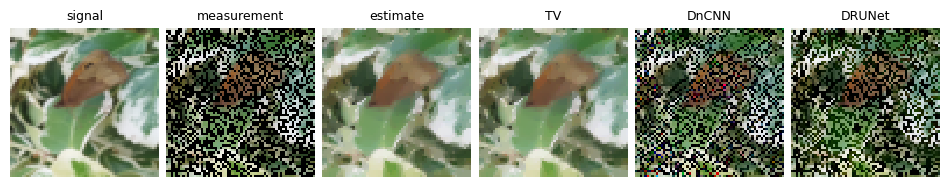

In [59]:
plot([img, y, x_hat, x_hat, x_model2, x_model3], ["signal", "measurement", "estimate", "TV", "DnCNN", "DRUNet"], rescale_mode='clip')

In [6]:
def PSNR(original, img, max_value = 1): 
    mse = np.mean((np.array(original, dtype=np.float32) - np.array(img, dtype=np.float32)) ** 2)
    if mse == 0:
        return 100
    psnr = 20 * np.log10(max_value / (np.sqrt(mse)))
    return psnr

def display_images(image_list, image_titles, ground_truth):
    titles = []
    for img, title in zip(image_list, image_titles):
        
        #cur_min = np.round(np.amin(img), 1)
        #cur_max = np.round(np.amax(img), 1)
        #bounds = '{} to {}'.format(str(cur_min), str(cur_max))
        psnr = PSNR(ground_truth, img)
        titles.append(title + f' PSNR: {psnr:.2f} dB \n')
        

        #nrmse = pnpm.nrmse(img, ground_truth)
        #titles.append(title + ' [NRMSE: ' + str(nrmse) + ']')

    for img, title in zip(image_list, titles):
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 5))
        

        ax.imshow(img, cmap='gray')
        #pnpm.display_image(img, fig=fig, ax=ax, cmap='gray')

        plt.suptitle(title)
        plt.tight_layout()
        fig.show()



In [ ]:
def soft_thresh(x, l):
    return np.sign(x) * np.maximum(np.abs(x) - l, 0.)


def denoiser(x, l, method):
        """
        Denoiser options to replace the proximal step
        """
        L = np.linalg.norm(A) ** 2  # Lipschitz constant
        if method == 'tv':
            return denoise_tv_chambolle(x, weight = 0.3)
        elif method == 'bm3d':
            return bm3d(x, sigma_psd = 5.9)
        elif method == 'proximal':
            return soft_thresh(x, l / L)


def pnp_ista(A, b, x_truth, method, l, iters, tol = 1e-3):
    """
    
    PnP iterative shrinkage thrseholding algorithm (PnP-FISTA)
    """
    x = np.zeros(A.shape[1])
    #minimisations = []
    psnrs = []
    L = np.linalg.norm(A) ** 2  # Lipschitz constant
    for i in tqdm(range(iters), desc = 'PnP PGD iterations'):
        #gradient descent step
        grad_g = A.T @ (A @ x - b)
        x_descent = x - (grad_g/ L)

        #denoising step
        x = denoiser(x_descent, l, method)
        #x = soft_thresh(x_descent, l / L)


        #current_min = 0.5 * np.linalg.norm(A.dot(x) - b) ** 2 + l * np.linalg.norm(x, 1)
        #minimisations.append(current_min)
        #diff = np.linalg.norm(x - x_truth)/np.linalg.norm(x_truth)
        psnr = PSNR(x_truth, x)
        psnrs.append(psnr)
        if np.linalg.norm(grad_g) <= tol:  # Termination criterion
            print('Iteration {}: gradient norm {:.4e} is less than tolerance {}\n'.format(i, np.linalg.norm(grad_g), tol))
            break

    print("Final PSNR:", psnr)

    return x, psnrs


def pnp_fista(A, b, x_g, method, l, iters, tol = 1e-3):
    """
    PnP FISTA (accelerated PGD)
    """
    #ground = 0.5 * np.linalg.norm(A.dot(x_g) - b) ** 2 + l * np.linalg.norm(x_g, 1)
    x = np.zeros(A.shape[1])
    psnrs = []

    #Initialisation of parameters (step size and initial guesses)
    t = 1
    z = x.copy()
    L = np.linalg.norm(A) ** 2
    for i in tqdm(range(iters), desc = 'PnP FISTA iterations'):
        grad_g = A.T @ (A @ x - b)
        xold = x.copy()
        z = z + A.T.dot(b - A.dot(z)) / L
        x = denoiser(z, l, method)
        t0 = t
        t = (1. + np.sqrt(1. + 4. * t ** 2)) / 2.
        z = x + ((t0 - 1.) / t) * (x - xold)
        
        #diff = np.linalg.norm(x - x_g)/np.linalg.norm(x_g)
        psnr = PSNR(x_g, x)
        psnrs.append(psnr)
        if np.linalg.norm(grad_g) <= tol:  # Termination criterion
            print('Iteration {}: gradient norm {:.4e} is less than tolerance {}\n'.format(k, np.linalg.norm(grad_g), tol))
            break

        """
        if i == 1:
          Xone = x
        elif i == 250:
          X250 = x

        """

    print("Final PSNR:", psnr)
        
        


    return x, psnrs


def plot_and_estimate_convergence(norm_res, alpha, ytitle, color='k'):
    K = len(norm_res)
    method = "$\\lambda = $" + str(alpha)
    plt.semilogy(norm_res, color=color, label=method)
    k = np.arange(K)

    plt.ylabel(ytitle)
    plt.xlabel('number of iterations: k')
    plt.legend()
    plt.grid(True)
